<a href="https://colab.research.google.com/github/EmiTR/Testprojekt-ET/blob/main/ET_dcgan_for_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will implement Deep Convolutional GAN (DCGAN) from [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf). Both the generator and discriminator are made up of convolutional layers. The dataset used here is MNIST Handwritten Digit dataset.

**Before executing the cell, go to Runtime -> Change Runtime Type -> GPU**

In [ ]:
import time 

# for building GAN
import torch
import torch.nn as nn  
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# for visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import make_grid
%matplotlib inline #to display plots within the notebook

# Using GPU


In [ ]:
X = torch.randn(3, 2) #tao tensor random, 3 hang 2 cot
print(X)

tensor([[ 0.8426, -1.1978],
        [-0.7131,  0.6024],
        [ 0.4679, -1.7031]])


In [ ]:
X.device

device(type='cpu')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
X = torch.randn(3, 2).to(device)
print(X.device)

cuda:0


# Prepare MNIST dataset

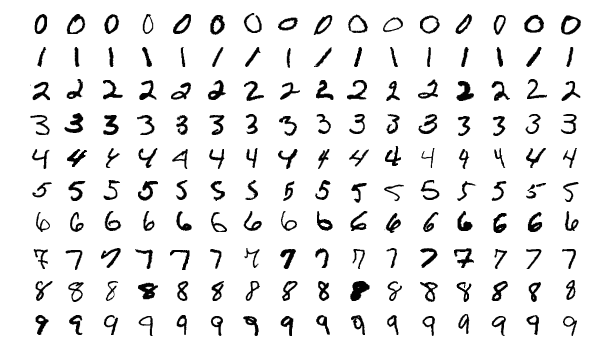

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/' # path to save MNIST dataset

In [ ]:
%cd gdrive//MyDrive
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz #downloading dataset from the link
!tar -zxvf MNIST.tar.gz #To extract the files from the tar archiver 

/content/gdrive/MyDrive
--2022-02-17 21:09:38--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2022-02-17 21:09:38--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [          <=>       ]  33.20M  2.20MB/s    in 15s     

2022-02-17 21:09:54 (2.15 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                # transform them to Tensors of normalized range [-1, 1]
                                transforms.Normalize((0.5,), (0.5,))
])
dataset = MNIST(path, train=True, download=True,
                transform = transform)           


In [ ]:
len(dataset)

60000

Min value: -1.0	 Max value: 1.0
Image size: torch.Size([1, 28, 28])
Label: 7


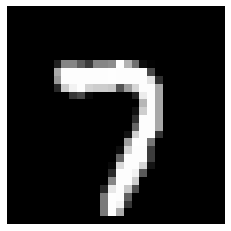

In [ ]:
# Show a random image
idx = np.random.choice(len(dataset)) # get a random index in range [0, len(dataset))
img, label = dataset[idx]
print('Min value: {}\t Max value: {}'.format(img.min().item(), img.max().item()))
print('Image size: {}'.format(img.shape))
print('Label: {}'.format(label))
plt.axis('off')
# torch.squeeze() method removes the dimensions of input of size 1
# input size of 28 x 28 x 1 will become 28 x 28
plt.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray') #?
plt.show()

In [ ]:
def show_images(image_tensor, num_images=25, nrow=5, save=False): 
  image_tensor = image_tensor.detach().to('cpu') 
  # convert the output values to the expected range of float pixel values [0, 1]
  image_tensor = (image_tensor + 1)/2  
  img = make_grid(image_tensor[:num_images], nrow=nrow).permute(1,2,0).squeeze()
  # if save is True, just return the image  
  if save:
    return img
  plt.axis('off')
  plt.imshow(img)
  plt.show()

In [ ]:
# create a dataloader
batch_size = 128
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

torch.Size([128, 1, 28, 28])


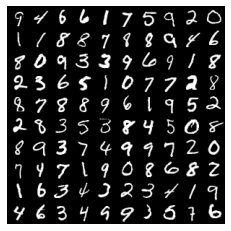

In [ ]:
for i, data in enumerate(dataloader):
  X, _ = data  
  print(X.shape)
  break

show_images(X, 100, 10)

# Input noise vector

In [ ]:
def noise_vector(num, dim):
  '''
  num: number of noise vectors, num = batch size in training process
  dim: dimension of each noise vector

  return: noise vectors of shape (num, dim, 1, 1)
  '''
  return torch.randn(num, dim, 1, 1)

In [ ]:
z = noise_vector(10, 100)
print(z.shape)

torch.Size([10, 100, 1, 1])


# Batch Normalization





*   Stabilize generator's learning process
*   Prevent mode collapse 



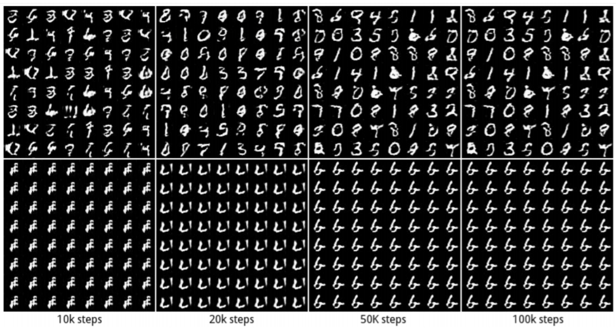

# Generator Model

**Each layer of generator:**


*   Transposed convolution for upsampling
*   Use batchnorm except for the last layer
*   Apply ReLU activation for all layers except for the output, which uses Tanh









https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11

**ReLU (Rectified Linear Unit)**

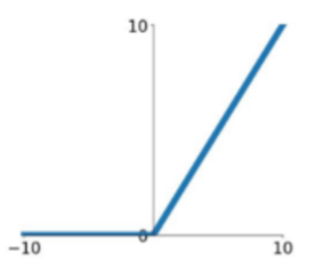

**Tanh**

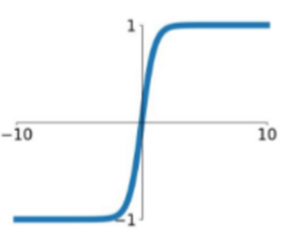


Remember that the output size of transposed convolution is:
$$output size = (input size -1)*stride - 2*padding + kernel size$$

Useful functions in building generator:


*   [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)
*   [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm#torch.nn.BatchNorm2d)
*   [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU)
*   [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh)

In [ ]:
class Generator(nn.Module):
  '''
  z_dim: the length of the input noise vector, a scalar
  hidden_dim: size of the feature maps that are propagated through the generator, a scalar
  out_channel: number of channels in the output image, set to 1 for MNIST (black and white)
  '''
  def __init__(self, zdim, hidden_dim=64, out_channel=1):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
        # layer 1, input is z (noise)
        self.generator_block(zdim, hidden_dim*4, 4),
        # size (hidden_dim*4) x 4 x 4

        # layer 2
        self.generator_block(hidden_dim*4, hidden_dim*2, 4, 2, 1),        
        # size (hidden_dim*2) x 8 x 8

        # layer 3
        self.generator_block(hidden_dim*2, hidden_dim, 4, 2, 2),                  
        # size (hidden_dim) x 14 x 14

        # layer 4 (last layer)
        self.generator_block(hidden_dim, out_channel, 4, 2, 1, last=True)        
        # output size out_channel x 28 x 28
    )

  def generator_block(self, in_channels, out_channels, kernel_size, stride=1, padding=0, last=False):
    if not last:
      gen_block = nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),        
          nn.BatchNorm2d(out_channels),
          nn.ReLU()        
      )
    else:
      gen_block = nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
          nn.Tanh()
      )
    return gen_block


  def forward(self, X):
    return self.model(X)

From the DCGAN paper, the author suggested to initialize all weights from a zero-centered Normal distribution with standard deviation 0.02.

In [ ]:
# apply to Generator and Discriminator network
def init_weights(m):
  if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
    nn.init.normal_(m.weight, mean=0.0, std=0.02)
  elif type(m) == nn.BatchNorm2d:
    nn.init.normal_(m.weight, mean=0.0, std=0.02)
    nn.init.constant_(m.bias, val=0.0)

In [ ]:
gen = Generator(100)
gen.apply(init_weights)
print(gen)

Generator(
  (model): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): Tanh()
    )
  )
)


torch.Size([1, 28, 28])


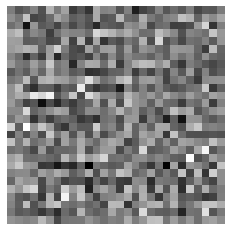

In [ ]:
z = noise_vector(1, 100)
fake = gen(z).detach()
print(fake[0].shape)

plt.axis('off')
plt.imshow(fake[0].permute(1, 2, 0).squeeze(), cmap='gray')
plt.show()

# Discriminator Model

**Each layer of discriminator:**


*   Convolution for downsampling
*   Use batchnorm except for the last layer
*   Apply LeakyReLU activation with slope of 0.2 for all layers 




**LeakyReLU**

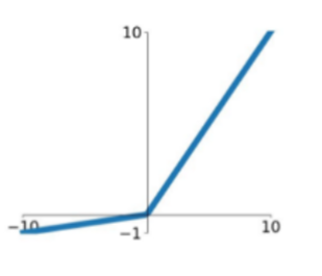

Remember that the output size of convolution is:
$$output size = (inputsize + 2*padding - kernelsize)/stride + 1$$

Useful functions in building discriminator:


*   [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d)
*   [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm#torch.nn.BatchNorm2d)
*   [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html?highlight=leaky%20relu#torch.nn.LeakyReLU)
*   [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html?highlight=sigmoid#torch.nn.functional.sigmoid)

In [ ]:
class Discriminator(nn.Module):
  '''
  im_channel: number of channels in the input image. Default is 1 for MNIST dataset
  hideen_dim: size of the feature maps that are propagated through the discriminator, a scalar
  '''
  def __init__(self, im_channel=1, hidden_dim=64):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        # layer 1, input is image of size im_channel x 28 x 28
        self.discriminator_block(im_channel, hidden_dim, 4, 2, 1),        
        # size (hidden_dim) x 14 x 14

        # layer 2
        self.discriminator_block(hidden_dim, hidden_dim*2, 4, 2, 2),        
        # size (hidden_dim*2) x 8 x 8

        # layer 3
        self.discriminator_block(hidden_dim*2, hidden_dim*4, 4, 2, 1),   
        # size (hidden_dim*4) x 4 x 4

        # layer 4 (last layer)
        self.discriminator_block(hidden_dim*4, 1, 4, last=True)  
        # output size 1 (probability)      
    )

  def discriminator_block(self, in_channels, out_channels, kernel_size, stride=1, padding=0, last=False):
    if not last:
      disc_block = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
          nn.BatchNorm2d(out_channels),
          nn.LeakyReLU(0.2)
      )
    else:
      disc_block = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
          nn.Sigmoid()
      )
    return disc_block
  
  def forward(self, image):
    out = self.model(image)
    return out.view(len(image), -1)

In [ ]:
disc = Discriminator()
disc.apply(init_weights)
print(disc)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
      (1): Sigmoid()
    )
  )
)


# Start Training

Useful function:



*   [torch.optim.Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)




In [ ]:
# define some important variables

# dimension of noise vector
z_dim = 100

device = "cuda" if torch.cuda.is_available() else "cpu"

# loss function
criterion = nn.BCELoss()

# initialize generator, discriminator, optimizer
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)
# randomly initialize the model weights from a normal distribution
gen.apply(init_weights)
disc.apply(init_weights)

# optimizers for both Generator and Discriminator
learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.999
optimG = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=(beta1, beta2))
optimD = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=(beta1, beta2))

In [ ]:
# fixed noise for visualization purpose
fixed_noise = noise_vector(100, z_dim).to(device)

In [ ]:
num_epochs = 20

img_list = []
gen_losses = []
disc_losses = []

iter = 0

start_time = time.time()
for epoch in range(num_epochs):
  for i, data in enumerate(dataloader):
    real = data[0].to(device)

    # update discriminator
    optimD.zero_grad()
    noise = noise_vector(len(real), z_dim).to(device)
    fake = gen(noise).detach()
    disc_fake_pred = disc(fake)
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)    
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss)/2

    # record discrimator loss for later visualization purpose
    disc_losses.append(disc_loss.item())
    # calculate gradients of discriminator
    disc_loss.backward()
    # update optimizer
    optimD.step()
    
    # update generator
    optimG.zero_grad()
    noise2 = noise_vector(len(real), z_dim).to(device)
    fake2 = gen(noise2)
    disc_fake_pred2 = disc(fake2)
    gen_loss = criterion(disc_fake_pred2, torch.ones_like(disc_fake_pred2))

    # record generator loss for later visualization purpose
    gen_losses.append(gen_loss.item())
    # calculate gradients of generator
    gen_loss.backward()
    # updatde optimizer
    optimG.step()

    # for every 250 iterations or the last batch of data in the last epoch,
    # use the fixed_noise to generate fake images to see the generator's learning progress   
    if iter % 250 == 0 or ((epoch == num_epochs-1) and (i == len(dataloader) - 1)):
      with torch.no_grad():
        fixed_fake = gen(fixed_noise)
        img = show_images(fixed_fake, len(fixed_fake), nrow=10, save=True)        
        img_list.append(img)
    iter+=1
  # training status
  print('[{}/{}]\tLoss_D: {:.5f}\tLoss_G: {:.5f}\tD(x): {:.5f}\tD(G(z)): {:.5f}/{:.5f}'.format(epoch+1, num_epochs, disc_loss.item(), gen_loss.item(), disc_real_pred.mean().item(), disc_fake_pred.mean().item(), disc_fake_pred2.mean().item()))

end_time = time.time()
print('Training process done! Time used: {} mins.'.format((end_time - start_time)/60))


[1/20]	Loss_D: 0.15634	Loss_G: 3.00248	D(x): 0.77092	D(G(z)): 0.03855/0.05367
[2/20]	Loss_D: 0.17994	Loss_G: 1.84698	D(x): 0.82824	D(G(z)): 0.14467/0.18313
[3/20]	Loss_D: 0.36755	Loss_G: 2.14337	D(x): 0.76183	D(G(z)): 0.33994/0.13983
[4/20]	Loss_D: 0.68354	Loss_G: 2.40810	D(x): 0.93855	D(G(z)): 0.69804/0.11175
[5/20]	Loss_D: 0.31897	Loss_G: 1.73581	D(x): 0.72800	D(G(z)): 0.24210/0.22166
[6/20]	Loss_D: 0.31510	Loss_G: 1.68920	D(x): 0.76949	D(G(z)): 0.27510/0.22605
[7/20]	Loss_D: 0.34131	Loss_G: 1.88715	D(x): 0.69659	D(G(z)): 0.23805/0.19432
[8/20]	Loss_D: 0.44506	Loss_G: 1.53463	D(x): 0.73593	D(G(z)): 0.40042/0.24084
[9/20]	Loss_D: 0.31224	Loss_G: 1.35265	D(x): 0.68642	D(G(z)): 0.18636/0.30273
[10/20]	Loss_D: 0.63097	Loss_G: 0.96931	D(x): 0.35641	D(G(z)): 0.06481/0.42683
[11/20]	Loss_D: 0.32412	Loss_G: 1.17237	D(x): 0.69004	D(G(z)): 0.21360/0.34919
[12/20]	Loss_D: 0.33923	Loss_G: 1.25733	D(x): 0.69958	D(G(z)): 0.23903/0.32752
[13/20]	Loss_D: 0.40795	Loss_G: 2.07582	D(x): 0.86921	D(G(z))

# Visualization

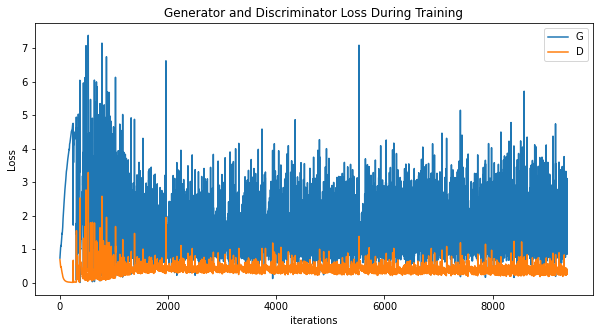

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="G")
plt.plot(disc_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

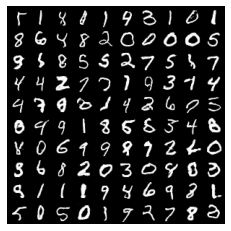

In [ ]:
fig = plt.figure()
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=500, blit=True)

HTML(ani.to_html5_video())

After the training process is done, we can use the generator model to generate new images!

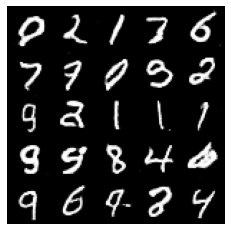

In [ ]:
# noise vector
noise = noise_vector(25, z_dim).to(device)
# pass the noise vectors to trained generator
imgs = gen(noise)
show_images(imgs)

# What's next


*   Using other datasets to train a GAN, for example [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) which is also available in *torchvision*
*   Explore methods to improve the stability of GAN learning. For anyone who is interested in this, can read more on Wasserstein GAN and Gradient Penalty. [WGAN-GP](https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490)
*   Explore Conditional GAN, which allows you to control the output.

Want to include GAN in your next project? Take a look at this Github repository [GANs Awesome Applications](https://github.com/nashory/gans-awesome-applications)!

